In [3]:


"""
    ####################################
    'loaddata.*'
    
    loads and shows audio data
    
    uses LIBROSA. Insall e.g. with

    conda install -c conda-forge librosa
    ####################################
"""


import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd

import sklearn

task_names = [
 ['Dog', 'Rooster', 'Pig', 'Cow', 'Frog', 'Cat'],
 ['Rain', 'Sea waves', 'Crackling fire', 'Crickets', 'Chirping birds', 'Water drops'],
 ['Hen', 'Insects (flying)', 'Sheep', 'Crow', 
  'Wind', 'Pouring water', 'Toilet flush',  'Thunderstorm', 
  'Laughing', 'Brushing teeth'],
 ['Crying baby', 'Sneezing', 'Clapping', 'Breathing', 'Coughing', 'Footsteps'],
 ['Door knock', 'Mouse click', 'Keyboard typing', 'Door, wood creaks', 'Can opening',
  'Washing machine'],
 ['Snoring',  'Drinking, sipping',
  'Vacuum cleaner', 'Clock alarm', 'Clock tick', 'Glass breaking',
  'Church bells', 'Airplane', 'Fireworks', 'Hand saw'],
 ['Helicopter', 'Chainsaw', 'Siren', 'Car horn', 'Engine', 'Train']]


print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

task=1
class_names = task_names[task-1]
srate = 22050        # sampling rate
c = len(class_names) # no. of classes

# load data
data = np.load('adata%d.npy'%task)

n,d = data.shape  # size and (raw) dimension
nc = n//c         # samples per class

print('%d samples from %d classes'%(n,c))
print('Raw dimension is %d corresponding to %.1f seconds of audio'%(d,d/srate))

# set up labs
labs = np.int16(np.kron(np.arange(c),np.ones(nc)))




%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
720 samples from 6 classes
Raw dimension is 66150 corresponding to 3.0 seconds of audio


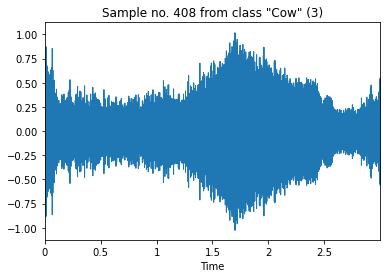

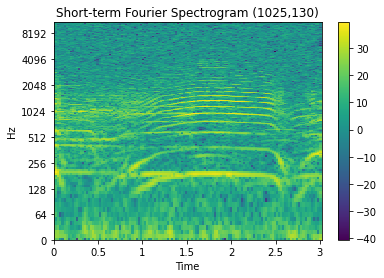

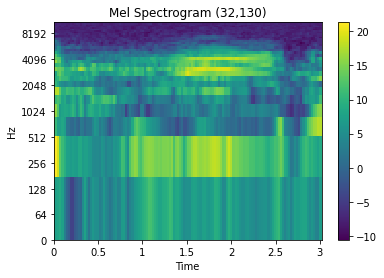

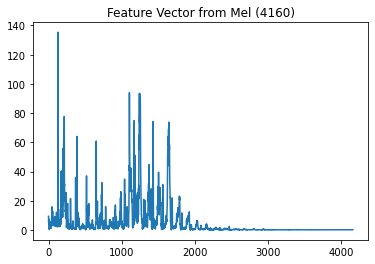

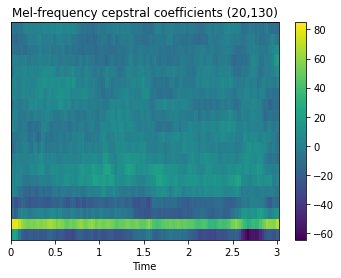

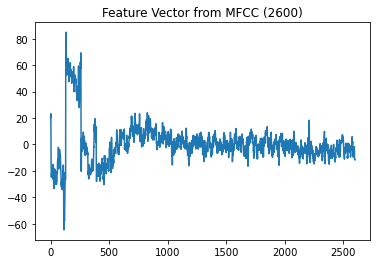

In [9]:
# take a row of the data matrix
arow = np.random.randint(n)

sig = data[arow,:]

fig,ax = plt.subplots()
librosa.display.waveplot(sig,ax=ax)
ax.set_title('Sample no. %d from class "%s" (%d)'%(arow,class_names[labs[arow]],labs[arow]))
plt.show()

Power = np.abs(librosa.stft(sig))**2
librosa.display.specshow(librosa.power_to_db(Power), sr=srate, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar()
plt.title('Short-term Fourier Spectrogram (%d,%d)'%Power.shape)
plt.show()

##########


Mel = librosa.feature.melspectrogram(y=sig, 
                                     sr=srate,n_mels=32)

librosa.display.specshow(librosa.power_to_db(Mel), sr=srate, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar()
plt.title('Mel Spectrogram (%d,%d)'%Mel.shape)
plt.show()

plt.plot(Mel.flatten())
plt.title('Feature Vector from Mel (%d)'%Mel.size)
plt.show()


##########


MFCC = librosa.feature.mfcc(y=sig, sr=srate, n_mfcc=20)
librosa.display.specshow(MFCC, sr=srate, x_axis='time', cmap='viridis')
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (%d,%d)'%MFCC.shape)
plt.show()

plt.plot(MFCC.flatten())
plt.title('Feature Vector from MFCC (%d)'%MFCC.size)
plt.show()

# Use this in NoteBooks only

ipd.Audio(sig, rate=srate)

Option 1:  take time domain representation and reduce dimensionality
Dimension: 66150 -> 486
Resub. acc of a linear class.: 0.77 -> 0.78
Option 2: use Mel spectrograms
Dimension: 4160 -> 231
Resub. acc of a linear class.: 0.92 -> 0.59
Option 3: use MFCCs
Dimension: 2600 -> 464
Resub. acc of a linear class.: 0.93 -> 0.94


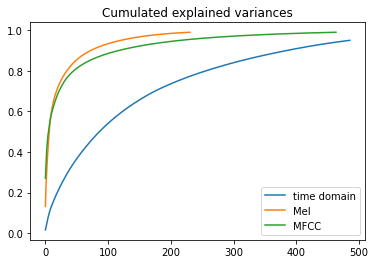

In [12]:
###########
# CREATE DATASET

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
wc = LinearDiscriminantAnalysis()

y = labs

print('Option 1:  take time domain representation and reduce dimensionality')

pca = sklearn.decomposition.PCA(n_components=.95)
pca.fit(data)
X = pca.transform(data)
print('Dimension: %d -> %d'%(data.shape[1],X.shape[1]))
plt.plot(np.cumsum(pca.explained_variance_ratio_),
         label='time domain')

print('Resub. acc of a linear class.: %.2f -> %.2f'%(wc.fit(data,y).score(data,y),wc.fit(X,y).score(X,y)))


print('Option 2: use Mel spectrograms')

Xm = librosa.feature.melspectrogram(y=data[0,:],
                        sr=srate,n_mels=32).flatten()    
for s in range(1,n):
    Mel = librosa.feature.melspectrogram(y=data[s,:],
                        sr=srate,n_mels=32).flatten()    
    Xm = np.vstack([Xm,Mel])

pca = sklearn.decomposition.PCA(n_components=.99)    
pca.fit(Xm)
X = pca.transform(Xm)
print('Dimension: %d -> %d'%(Xm.shape[1],X.shape[1]))
plt.plot(np.cumsum(pca.explained_variance_ratio_),
         label='Mel')

print('Resub. acc of a linear class.: %.2f -> %.2f'%(wc.fit(Xm,y).score(Xm,y),wc.fit(X,y).score(X,y)))

    
print('Option 3: use MFCCs')

Xf = librosa.feature.mfcc(y=data[0,:],
                        sr=srate,n_mfcc=20).flatten()    
for s in range(1,n):
    Mfcc = librosa.feature.mfcc(y=data[s,:],
                        sr=srate,n_mfcc=20).flatten()    
    Xf = np.vstack([Xf,Mfcc])

pca = sklearn.decomposition.PCA(n_components=.99)    
pca.fit(Xf)
X = pca.transform(Xf)
print('Dimension: %d -> %d'%(Xf.shape[1],X.shape[1]))    
plt.plot(np.cumsum(pca.explained_variance_ratio_),
         label='MFCC')

print('Resub. acc of a linear class.: %.2f -> %.2f'%(wc.fit(Xf,y).score(Xf,y),wc.fit(X,y).score(X,y)))

############
plt.title('Cumulated explained variances')
plt.legend()
plt.show()
